# Cloud Cover Detection Competition Benchmark Model

For my final project in CS6140, instead of looking at CIFAR-10, the problem I am trying to solve is cloud cover detection from satellite imagery using RGB and infrared bands. This labeled dataset was provided by DrivenData as part of a public competition using Sentinel2 satellite imagery. This is a tricky problem because many other objects can look like clouds, such as snow and glaciers, fire smoke etc., but not be clouds. Often multispectral data will have other bands of information that might help a researcher to distinguish between clouds and other cloud-like objects in the image. This is an important problem to solve because at any given moment a large percent of the land is covered by clouds from the sky, and clouds obscure the environmental or industrial insights that hide below. This makes solving problems with satellite data like crop cover, land-use change, and flood detection very difficult at times.

You can learn more details about DrivenData competitions and the cloud cover detection competition specifically here: https://www.drivendata.org/competitions/83/

For this project I decided to use PyTorch instead of Tensorflow, firstly because I'm already very familiar with Tensorflow Keras API, and also because I wanted to contribute to a project by a small Microsoft team to develop a geospatial wrapper toolkit on PyTorch Lightning Modules. This makes for very efficient downloading of datasets and training of models using pretrained models. The PyTorch wrapper library that I used is called `torchgeo`. The project can be found on GitHub here: https://github.com/microsoft/torchgeo

Because the cloud cover detection dataset has not been integrated into the `torchgeo` library yet, this mean I had to make a DataModule wrapper for the dataset. This makes it possible for LightningModule to load the data and train a model, regardless of which architecture is chosen. This is where I spent the greatest amount of time after running through the benchmark Unet model without `torchgeo`, and I am still struggling with this process. Therefore the primary component of my project submission will be this notebook, and the `cloud_cover_model.ipynb` is the notebook where I was testing to integrate the custom DataModule for the cloud cover detection dataset (still in the works). Credit for most of the code for this notebook comes from this blog: https://www.drivendata.co/blog/cloud-cover-benchmark/

The latest issue submitted to the `torgegeo` Github project is here: https://github.com/microsoft/torchgeo/issues/303

In [30]:
from IPython.display import Image

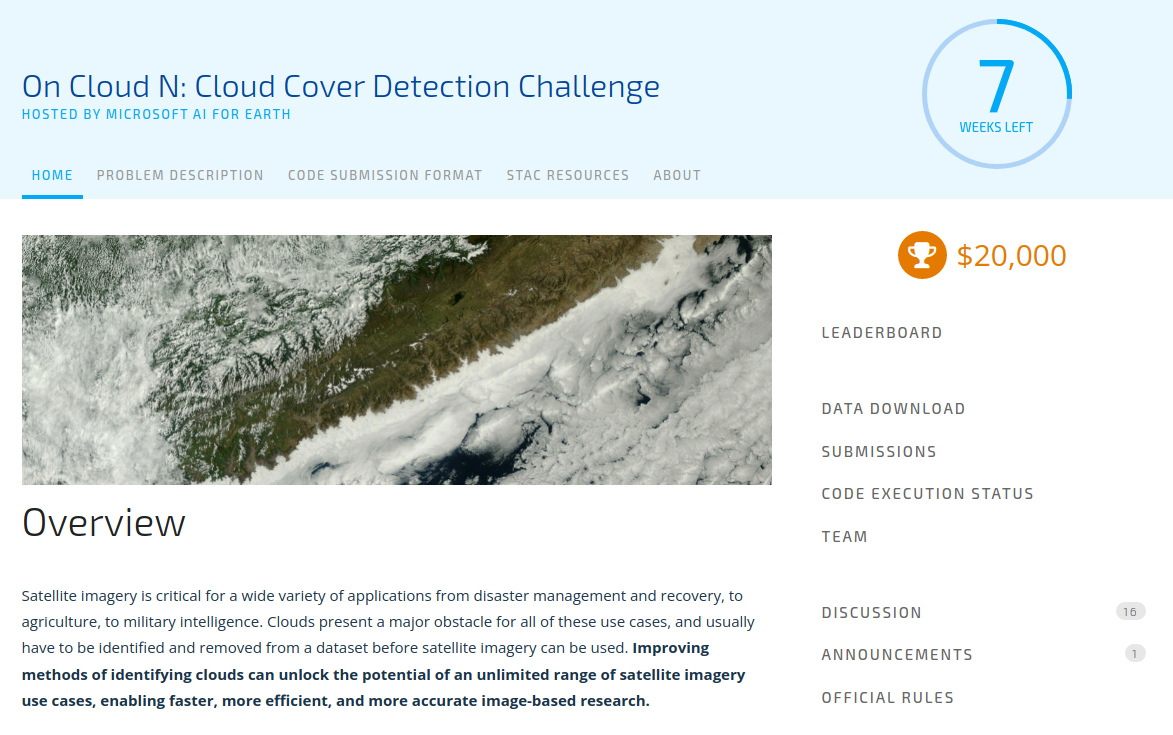

In [42]:
Image('./cloud_competition_landing_page.png')

In [1]:
import warnings

warnings.filterwarnings("ignore")

## Import required libraries

Here we import some common python libraries, as well as the required PyTorch and geospatial libraries

In [2]:
import shutil
import rasterio
import random
from rasterio.plot import show
import pyproj
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_path import path
from pathlib import Path
from PIL import Image
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch
from typing import Optional, List

In [3]:
import xarray
import xrspatial.multispectral as ms

## Define global variables

In [43]:
PROJECT_DIR = Path.cwd().parent.resolve() / "cloud_cover_competition"
DATA_DIR = PROJECT_DIR / "data"
print(DATA_DIR)

TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"

assert TRAIN_FEATURES.exists()

/home/ying/cloud_cover_competition/data


In [44]:
BANDS = ["B02", "B03", "B04", "B08"]

## Import the metadata CSV

In [45]:
train_meta = pd.read_csv(PROJECT_DIR / "train_metadata.csv")
train_meta.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj


In [46]:
train_meta[["chip_id","location","datetime"]].nunique()

chip_id     11748
location       81
datetime       91
dtype: int64

## Observe the distribution of image chips by location

In [47]:
train_location_counts = (
    train_meta.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

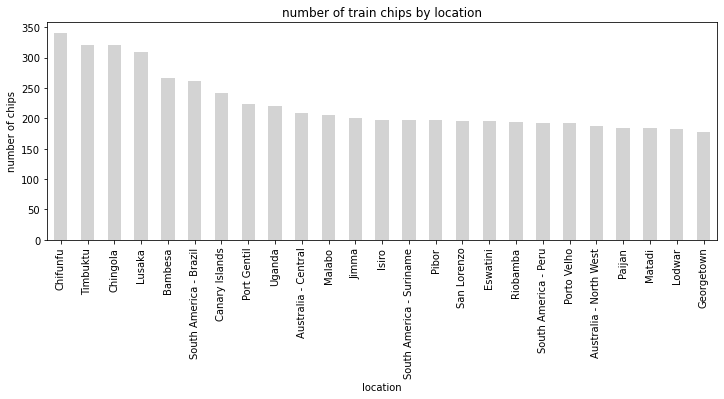

In [48]:
plt.figure(figsize=(12,4))
train_location_counts.head(25).plot(kind="bar", color="lightgray")
plt.xticks(rotation=90)
plt.xlabel("location")
plt.ylabel("number of chips")
plt.title("number of train chips by location")
plt.show()

From the above distribution, we can see that in the top 25 locations, the data is pretty evenly distributed.

## Summarize the metadata by year and location

In [49]:
train_meta["datetime"] = pd.to_datetime(train_meta["datetime"])

In [50]:
train_meta["year"] = train_meta.datetime.dt.year

In [51]:
train_meta.groupby("year")[["chip_id"]].nunique().sort_index().rename(columns={"chip_id": "chip_count"})

,chip_count
year,
2018,326
2019,1015
2020,10407


In [52]:
train_meta["datetime"].min(), train_meta[
    "datetime"
].max()

(Timestamp('2018-03-07 08:46:02+0000', tz='UTC'),
 Timestamp('2020-09-14 08:28:49+0000', tz='UTC'))

In [53]:
chips_per_locationtime = (
    train_meta.groupby(["location", "datetime"])[["chip_id"]]
    .nunique()
    .sort_values(by="chip_id", ascending=False)
    .rename(columns={"chip_id": "chip_count"})
)
chips_per_locationtime.head(10)

,,chip_count
location,datetime,
South America - Brazil,2020-09-06 15:02:37+00:00,261
Port Gentil,2020-09-08 09:50:58+00:00,223
Uganda,2019-04-25 08:29:37+00:00,220
Australia - Central,2020-08-11 01:24:00+00:00,209
Malabo,2020-09-06 10:00:03+00:00,206
Jimma,2020-05-31 08:07:58+00:00,201
Chifunfu,2020-04-29 08:20:47+00:00,197
South America - Suriname,2020-06-03 14:11:18+00:00,197
Isiro,2020-08-28 08:39:29+00:00,197


## Build full paths to each GeoTiff by band and label

In [54]:
# this function looks in the feature and label directories for GeoTiff files, and assign file paths to the dataframe

def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        assert df[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        assert df["label_path"].path.exists().all()
        
    return df

In [55]:
train_meta = add_paths(train_meta, TRAIN_FEATURES, TRAIN_LABELS)
train_meta.head()

,chip_id,location,datetime,cloudpath,year,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwp,2020,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
1,adwu,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwu,2020,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
2,adwz,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwz,2020,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
3,adxp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adxp,2020,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
4,aeaj,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/aeaj,2020,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...


In [56]:
train_meta.loc[0, "label_path"]

PosixPath('/home/ying/cloud_cover_competition/data/train_labels/adwp.tif')

In [57]:
example_chip = train_meta[train_meta["chip_id"]=="pbyl"]
display(example_chip)

,chip_id,location,datetime,cloudpath,year,B02_path,B03_path,B04_path,B08_path,label_path
6571,pbyl,Lodwar,2020-09-08 08:09:15+00:00,az://./train_features/pbyl,2020,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...


## Display a sample image chip

In [58]:
example_chip = example_chip.iloc[0]
with rasterio.open(example_chip["B04_path"]) as img:
    chip_metadata = img.meta
    img_array = img.read(1)

In [59]:
chip_metadata

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 771935.0,
        0.0, -10.0, 331300.0)}

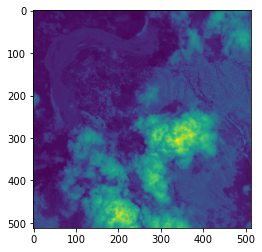

In [22]:
plt.imshow(img_array)

Here we can see an image of the red band for this specific chip, with the clouds depicted in the brighter yellow/grean colors as they are higher up in elevation, where the ground surface and a river is in darger greens and blues.

In [23]:
with rasterio.open(example_chip["B04_path"]) as img:
    lon, lat = img.lnglat()
    bounds = img.bounds
print(f"Longitude: {lon}, latitude: {lat}")

Longitude: 35.46935026347422, latitude: 2.9714117132510944


In [24]:
bounds

BoundingBox(left=771935.0, bottom=326180.0, right=777055.0, top=331300.0)

In [25]:
def lat_long_bounds(filepath):
    with rasterio.open(filepath) as im:
        bounds = im.bounds
        meta = im.meta
    current_crs = pyproj.CRS(meta["crs"])
    crs_transform = pyproj.Transformer.from_crs(current_crs, current_crs.geodetic_crs)
    return crs_transform.transform_bounds(*bounds)

In [26]:
left, bottom, right, top = lat_long_bounds(example_chip["B04_path"])
print(
    f"Image coordinates (lat, long): \n Start: ({left}, {bottom})"
    f"\nEnd: ({right}, {top})"
)

Image coordinates (lat, long): 
 Start: (2.948221298028172, 35.44628398518643)
End: (2.9946024439490517, 35.492417498478574)


## Define methods to extract true color RGB images

By default, Sentinel2 data is split across multiple bands, so that means that in order to see a true color image (RGB) like our eyes are used to seeing, you have to construct/stack an array of the separate bands, going from red (B04) + green (B03) + blue (B02). This stack is then able to be shown in true color (below).

In [27]:
def get_xarray(filepath):
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])

In [28]:
def true_color_img(chip_id, data_dir=TRAIN_FEATURES):
    chip_dir = data_dir / chip_id
    red = get_xarray(chip_dir / "B04.tif")
    green = get_xarray(chip_dir / "B03.tif")
    blue = get_xarray(chip_dir / "B02.tif")
    return ms.true_color(r=red, g=green, b=blue)

Text(0.5, 1.0, 'True color image for chip ID pbyl')

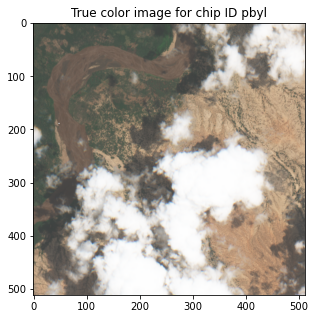

In [29]:
fig, ax = plt.subplots(figsize=(5,5))
im = true_color_img(example_chip.chip_id)
ax.imshow(im)
plt.title(f"True color image for chip ID {example_chip.chip_id}")

In [30]:
def display_random_chip(random_state):
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    random_chip = train_meta.sample(random_state=random_state).iloc[0]
    chid, location, label = random_chip.chip_id, random_chip.location, random_chip.label_path
    ax[0].imshow(true_color_img(chid))
    ax[0].set_title(f"Chip {chid}\n(Location: {location})")
    label_im = Image.open(label)
    print(np.array(label_im))
    ax[1].imshow(label_im)
    ax[1].set_title(f"Chip {chid} label")
    plt.tight_layout()
    plt.show()

Now that we have a method for displaying the true color image, we can display it next to the corresponding mask, which in this case is simply an array of 0s and 1s, indicating if the pixel is a cloud or not.

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


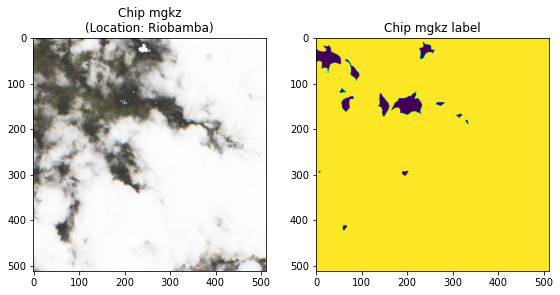

In [31]:
display_random_chip(1)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


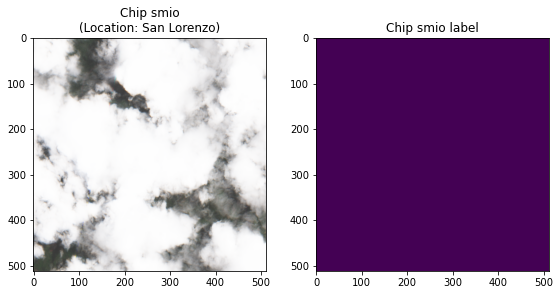

In [32]:
display_random_chip(23)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


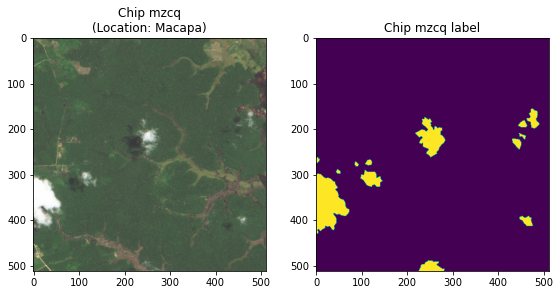

In [33]:
display_random_chip(9)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


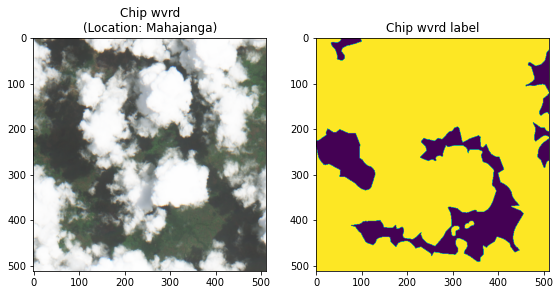

In [34]:
display_random_chip(40)

## Split the metadata dataframe into train, test and validation

Since all of the paths to the image bands and labels are in the dataframe, we can simply split up the dataframe to train, test and validation sets.

In [60]:
random.seed(9)

Get random sample indices to separate train from validation

In [61]:
chip_ids = train_meta.chip_id.unique().tolist()
val_chip_ids = random.sample(chip_ids, round(len(chip_ids) * 0.33))

val_mask = train_meta.chip_id.isin(val_chip_ids)
val = train_meta[val_mask].copy().reset_index(drop=True)
train = train_meta[~val_mask].copy().reset_index(drop=True)

val.shape, train.shape

((3877, 10), (7871, 10))

Split the metadata  dataframe into X and y for train and validation

In [62]:
feature_cols = ["chip_id"] + [f"{band}_path" for band in BANDS]

val_x = val[feature_cols].copy()
val_y = val[["chip_id", "label_path"]].copy()

train_x = train[feature_cols].copy()
train_y = train[["chip_id", "label_path"]].copy()

Split the test set off from the validation indices

In [63]:
test_chip_ids = random.sample(chip_ids, round(len(val) * .5))
test_mask = train_meta.chip_id.isin(test_chip_ids)
test = train_meta[test_mask].copy().reset_index(drop=True)
test_x = test[feature_cols].copy()
test_y = test[["chip_id","label_path"]].copy()

In [64]:
val_x.head()

,chip_id,B02_path,B03_path,B04_path,B08_path
0,adwz,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
1,aeej,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
2,aeey,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
3,aegb,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
4,aeky,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...


In [39]:
val_y.head()

,chip_id,label_path
0,adwz,/home/ying/cloud_cover_competition/data/train_...
1,aeej,/home/ying/cloud_cover_competition/data/train_...
2,aeey,/home/ying/cloud_cover_competition/data/train_...
3,aegb,/home/ying/cloud_cover_competition/data/train_...
4,aeky,/home/ying/cloud_cover_competition/data/train_...


In [62]:
test_x.head()

,chip_id,B02_path,B03_path,B04_path,B08_path
0,aebi,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
1,aegb,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
2,aesb,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
3,aesz,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
4,aevh,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...


In [63]:
test_y.head()

,chip_id,label_path
0,aebi,/home/ying/cloud_cover_competition/data/train_...
1,aegb,/home/ying/cloud_cover_competition/data/train_...
2,aesb,/home/ying/cloud_cover_competition/data/train_...
3,aesz,/home/ying/cloud_cover_competition/data/train_...
4,aevh,/home/ying/cloud_cover_competition/data/train_...


In [59]:
submission_dir = Path("benchmark_src")
# if submission_dir.exists():
#     shutil.rmtree(submission_dir)

if not submission_dir.exists():
    submission_dir.mkdir(parents=True)

## Train a Semantic Segmentation Model with Unet Architecture (& ResNet34 backbone)

The Unet architecture is an encoder-decoder model that literally looks like a U shape, with the encoder on the left half of the model graph and the decoder on the right half of the model graph. The architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization. This architecture was developed by researchers in bioinformatics trying to segment medical images to detect disease. For more information on how this architecture works, please reference the original research paper published here: https://arxiv.org/abs/1505.04597

![image](https://www.researchgate.net/profile/Alan-Jackson-2/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

In [40]:
# this is the custom CloudModel class
from benchmark_src.cloud_model import CloudModel

In [41]:
cloud_model = CloudModel(
    bands=BANDS,
    x_train=train_x,
    y_train=train_y,
    x_val=val_x,
    y_val=val_y
)

In [42]:
# Checkpoint callback writes progress on each epoch batch
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="iou_epoch", mode="max", verbose=True
)

In [43]:
# Early Stopping callback looks for when the model stops improving
early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor="iou_epoch",
    patience=(cloud_model.patience * 3),
    mode="max",
    verbose=True,
)

In [44]:
# This instantiates a PyTorch Lightning Trainer object
trainer = pl.Trainer(
    gpus=1,
    fast_dev_run=False,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [45]:
# check to make sure GPU is available
torch.cuda.is_available()

True

In [46]:
# Empty the cache in case something else is using GPU
torch.cuda.empty_cache()

In [ ]:
# train the model!!!
trainer.fit(model=cloud_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 24.4 M
-------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.759    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved. New best score: 0.840
Epoch 0, global step 983: iou_epoch reached 0.84010 (best 0.84010), saving model to "/home/ying/cloud_cover_competition/lightning_logs/version_6/checkpoints/epoch=0-step=983.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.842
Epoch 1, global step 1967: iou_epoch reached 0.84233 (best 0.84233), saving model to "/home/ying/cloud_cover_competition/lightning_logs/version_6/checkpoints/epoch=1-step=1967.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.012 >= min_delta = 0.0. New best score: 0.855
Epoch 2, global step 2951: iou_epoch reached 0.85458 (best 0.85458), saving model to "/home/ying/cloud_cover_competition/lightning_logs/version_6/checkpoints/epoch=2-step=2951.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.009 >= min_delta = 0.0. New best score: 0.864
Epoch 3, global step 3935: iou_epoch reached 0.86354 (best 0.86354), saving model to "/home/ying/cloud_cover_competition/lightning_logs/version_6/checkpoints/epoch=3-step=3935.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.008 >= min_delta = 0.0. New best score: 0.872
Epoch 4, global step 4919: iou_epoch reached 0.87164 (best 0.87164), saving model to "/home/ying/cloud_cover_competition/lightning_logs/version_6/checkpoints/epoch=4-step=4919.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 5903: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.872
Epoch 6, global step 6887: iou_epoch reached 0.87205 (best 0.87205), saving model to "/home/ying/cloud_cover_competition/lightning_logs/version_6/checkpoints/epoch=6-step=6887.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 7871: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 8855: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 9839: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 10823: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 11807: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 12791: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 13775: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.872
Epoch 14, global step 14759: iou_epoch reached 0.87243 (best 0.87243), saving model to "/home/ying/cloud_cover_competition/lightning_logs/version_6/checkpoints/epoch=14-step=14759.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

In [28]:
# checkpoint_file = '/home/ying/cloud_cover_competition/benchmark_logs/lightning_logs/version_6/checkpoints/epoch=14-step=14759.ckpt'

In [27]:
# checkpoint = torch.load(checkpoint_file)

In [26]:
# checkpoint.keys()

In [24]:
# checkpoint['callbacks']

In [25]:
# checkpoint['lr_schedulers']

In [23]:
# checkpoint['optimizer_states']

In [29]:
# cloud_model.load_state_dict(checkpoint['state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

In [57]:
# cloud_model.state_dict()

In [60]:
submission_assets_dir = submission_dir / "assets"
submission_assets_dir.mkdir(parents=True, exist_ok=True)

model_weight_path = submission_assets_dir / "cloud_model.pt"
torch.save(cloud_model.state_dict(), model_weight_path)

## Model Training Evaluation

Unlike the other classification and regression models we've been building for Fall '20 CS6140 at Northeastern University, which used evaluation metrics like F-score and MSE respectively, image segmentation problems in research and application commonly use the metric called Intersection over Union (or IoU). What this means is a simple ratio of the total area of intersection/overlap between a prediction and groundtruth, divided by the union of the two. This yields a ratio that looks like accuracy, and in some ways it is, because in semantic segmentation, the problem is to classify each pixel in the image with a class. In this case there were only two classes to predict, cloud or not cloud.

For the loss metric in training the Unet model, I used a Cross Entropy loss, but the other alternative would have been to use Jaccardian, which immulates IoU very well.  Below you can see the train and validation IoU and loss for each epoch in the TensorBoard dashboard that is displayed via my localhost server on port 6006. This view allows me to see all the different runs and their performance outcomes.

The **best IoU score** that was achieved in the 6th run on the 15th epoch was **0.872** and the **lowest loss** was approx **0.22**. In summary the model did a pretty good job, and by looking at the competition submission leaderboard, the best score so far is 0.891, so it would likely be difficult to get much better results than this.  Perhaps with another model architecture or playing with hyperparameters I could squeeze out a little more performance. However training this model took at least a few hours, and the early stopping errored out, otherwise this might have gone for even longer because by default the early stopping was set to end training when there were 12 epochs without improvement in model performance.

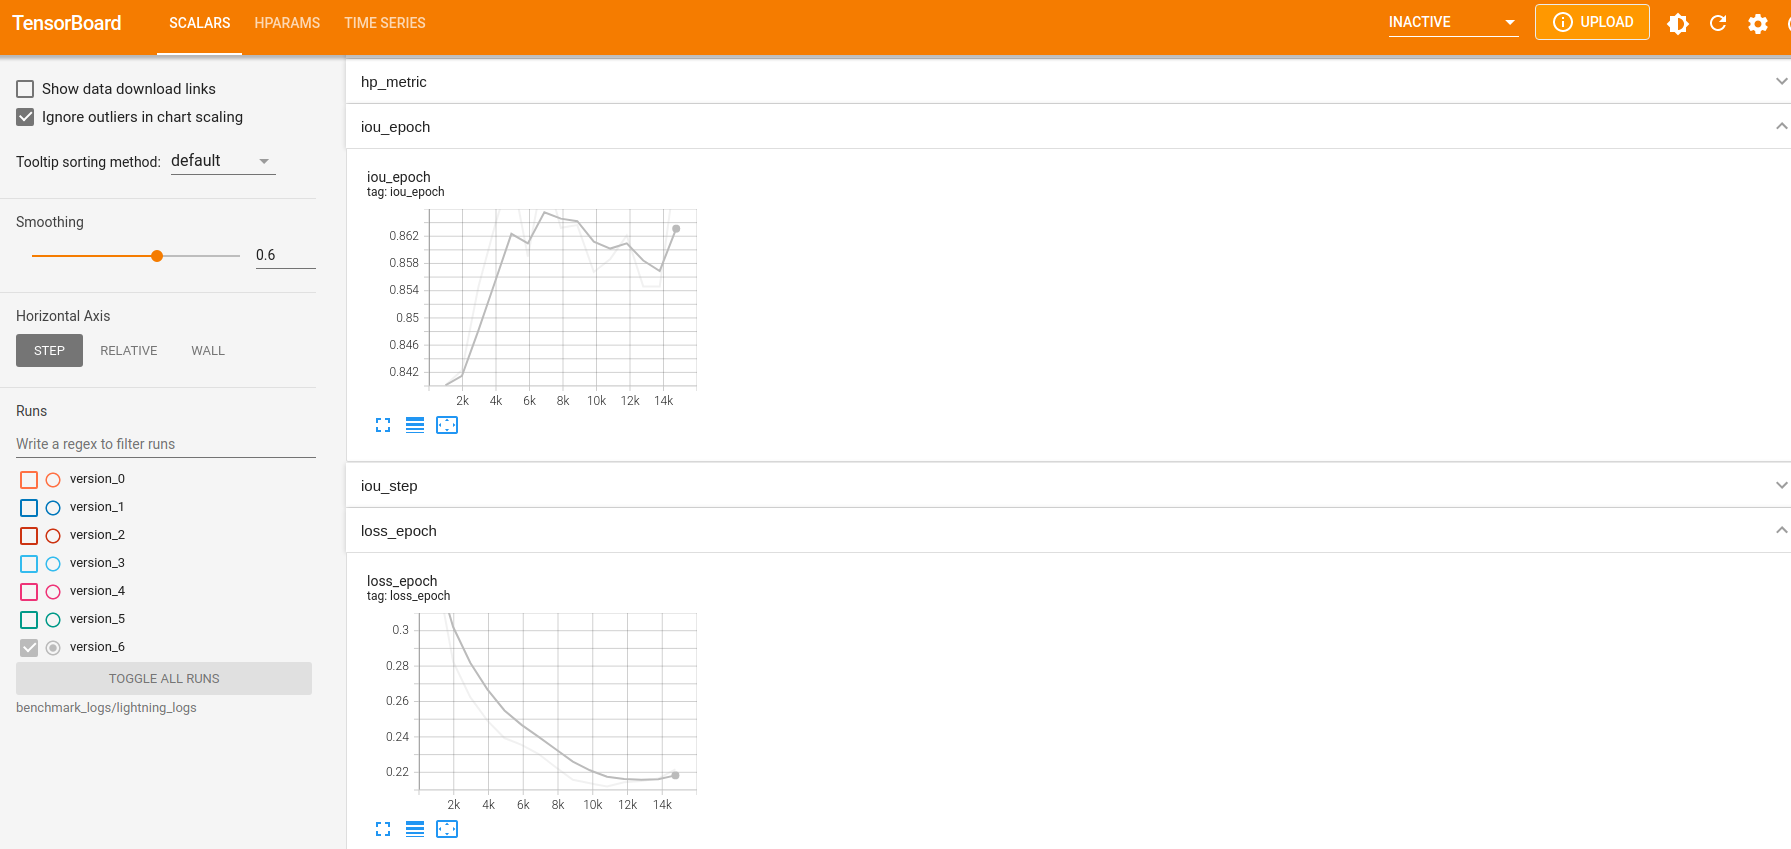

In [39]:
Image('./full_tensorboard_view.png')

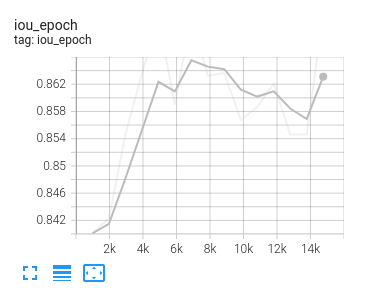

In [40]:
Image('./iou_per_epoch.png')

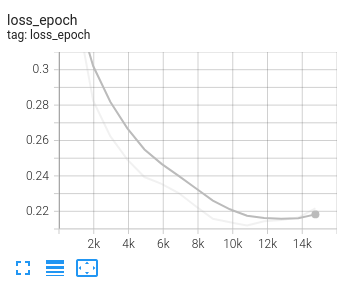

In [41]:
Image('./loss_per_epoch.png')

## Model Test Evaluation

The dataset from this competition didn't provide a test set, they kept it reserved for model submission only. The model code to perform the benchmark on this dataset also didn't provide a way to load the test dataset. This would have required modifying the CloudUNetModel (which is a PyTorch LightningModule) to include attributes to store the test dataset, as well as coding dataloaders etc. This is where I split off, and after talking with the Microsoft team for `torchgeo`, started work on coding the custom DataModule to integrate with their library. Long-term this will be a contribute to the repo. Also, when I submitted the results from the benchmark to DrivenData, the job was queued up, and eventually failed, but didn't provide an explanation as to why. This was a frustrating occurance when trying to get my test evaluation based on submission.